
--- Transaction & Throughput ---
Raw sub-weight sum (before normalization): 0.5600
Category weight: 0.20
  txs_daily -> final weight: 0.0286
  erc20_transfers_daily -> final weight: 0.0429
  erc721_transfers_daily -> final weight: 0.0429
  erc1155_transfers_daily -> final weight: 0.0429
  internal_operations_daily -> final weight: 0.0429

--- Smart Contract ---
Raw sub-weight sum (before normalization): 0.1100
Category weight: 0.15
  contracts_daily -> final weight: 0.0818
  contracts_verified_daily -> final weight: 0.0682

--- User Activity ---
Raw sub-weight sum (before normalization): 0.2500
Category weight: 0.25
  senders_daily -> final weight: 0.0700
  receivers_daily -> final weight: 0.0700
  unique_addresses_daily -> final weight: 0.0600
  addresses_daily -> final weight: 0.0500

--- Cost & Resource ---
Raw sub-weight sum (before normalization): 0.0700
Category weight: 0.10
  gas_used_daily -> final weight: 0.0714
  burned_fees_daily -> final weight: 0.0286

--- Value & Liquidi

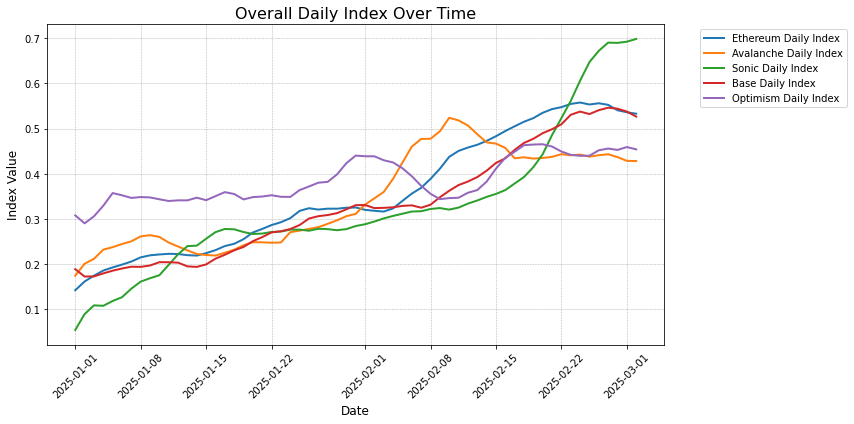

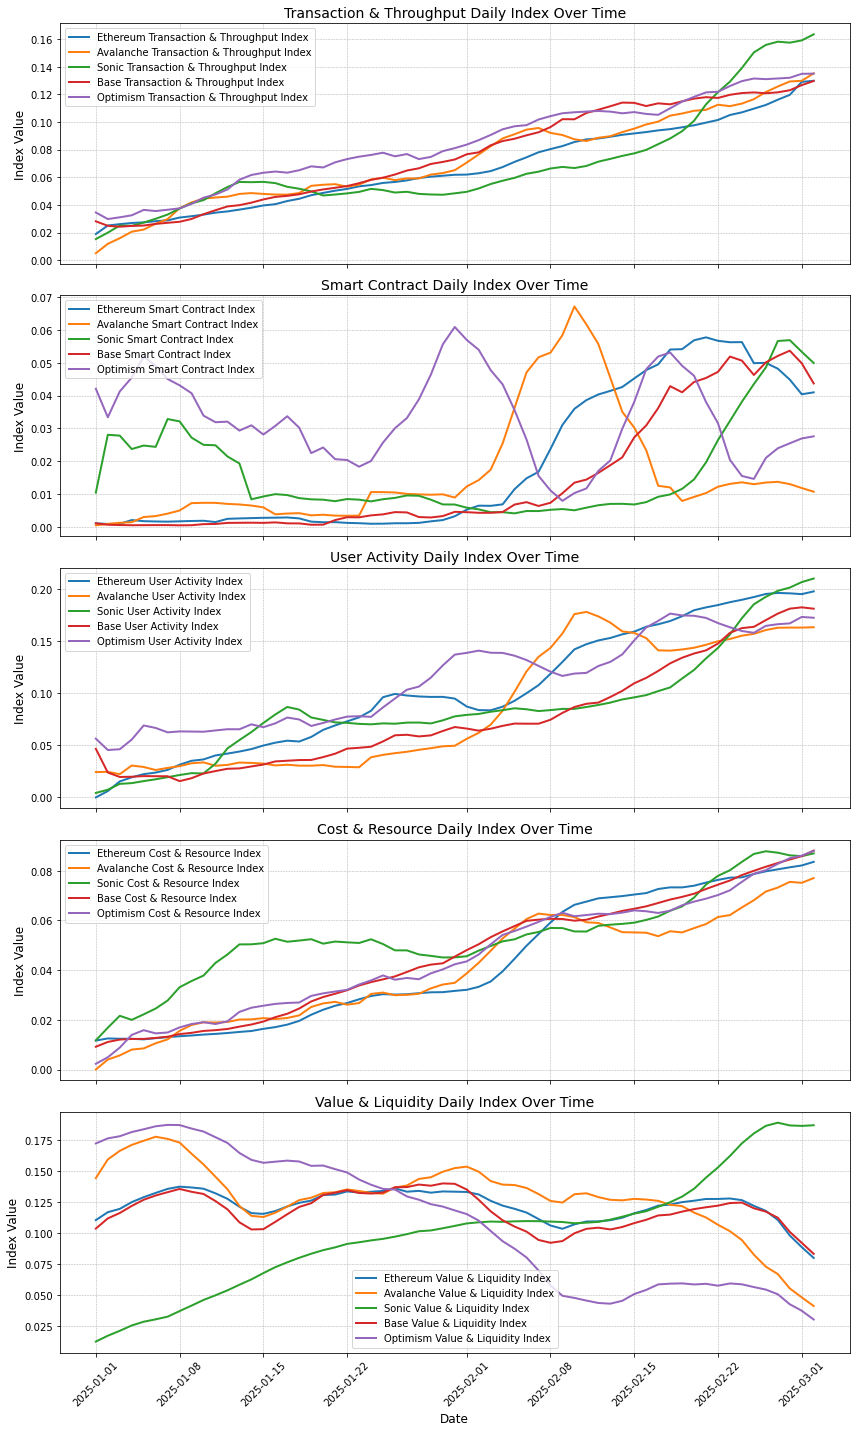

In [9]:
# %% [markdown]
# # Blockchain Performance Dashboard
#
# **Overview:**  
# This dashboard computes a composite index based on several blockchain performance metrics.
# For each metric, both daily and cumulative values are normalized and combined using a weighted average.
# The index is computed using expert-assigned weights for different sub‑categories, which are then aggregated into an overall index.
#
# **What You See:**  
# - Detailed calculation examples (with sample values) for each metric.  
# - Plots of the overall index and sub‑category indexes over time.
#
# **Feedback Requested:**  
# Please review the rationale behind the weights and the calculations and share your thoughts!

# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib.dates as mdates

# %% [markdown]
# ## 1. Normalization & Transformation Functions
#
# The functions below:
# - Convert inputs to numeric (coercing non-numeric values to NaN).
# - Fill missing values with the median.
# - Apply a logarithmic transform (for metrics that tend to grow exponentially).
# - Use RobustScaler (to reduce the impact of outliers) followed by MinMaxScaler to bring values into the [0, 1] range.

# %%
def log_transform(series):
    """Logarithmic transform for exponential-like data."""
    return np.log1p(series)

def robust_normalize(series, metric_name):
    """
    Converts the series to numeric (coercing non-numeric values),
    fills missing values with the median, applies log transform if needed,
    then applies RobustScaler followed by MinMaxScaler.
    """
    # Convert series to numeric, forcing non-numeric values to NaN.
    series = pd.to_numeric(series, errors='coerce')
    if series.isna().all():
        return series

    s = series.fillna(series.median()).copy()
    
    # Apply log transform for exponential metrics.
    exponential_metrics = [
        "txs_daily", "gas_used_daily", "burned_fees_daily",
        "tvl_daily", "stablecoins_daily",
    ]
    if metric_name in exponential_metrics or metric_name.replace("_cumulative", "_daily") in exponential_metrics:
        s = log_transform(s)
        
    # Robust scaling: subtract the median and scale by the IQR.
    robust_scaler = RobustScaler(quantile_range=(25, 75))
    s_robust = robust_scaler.fit_transform(s.values.reshape(-1, 1)).flatten()
    
    # MinMax scaling to [0,1].
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    s_minmax = minmax_scaler.fit_transform(s_robust.reshape(-1, 1)).flatten()
    
    return pd.Series(s_minmax, index=series.index)

# %% [markdown]
# ## 2. Category Weights & Raw Sub‑Weights
#
# We assign top‑level category weights (based on expert judgment) and raw sub‑weights within each category.
# These raw sub‑weights are normalized later so that each category contributes exactly its designated share to the overall index.

# %%
# Top‑level category weights.
category_weights = {
    "Transaction & Throughput": 0.20,
    "Smart Contract": 0.15,
    "User Activity": 0.25,
    "Cost & Resource": 0.10,
    "Value & Liquidity": 0.20,
}

# Raw sub‑weights for each category.
subweights_t_and_t = {
    "txs_daily": 0.08,
    "erc20_transfers_daily": 0.12,
    "erc721_transfers_daily": 0.12,
    "erc1155_transfers_daily": 0.12,
    "internal_operations_daily": 0.12,
}

subweights_smart_contract = {
    "contracts_daily": 0.06,
    "contracts_verified_daily": 0.05,
}

subweights_user_activity = {
    "senders_daily": 0.07,
    "receivers_daily": 0.07,
    "unique_addresses_daily": 0.06,
    "addresses_daily": 0.05,
}

subweights_cost_and_resource = {
    "gas_used_daily": 0.05,
    "burned_fees_daily": 0.02,
}

subweights_value_liquidity = {
    "tvl_daily": 0.07,
    "stablecoins_daily": 0.03,
}

raw_subweights = {
    "Transaction & Throughput": subweights_t_and_t,
    "Smart Contract": subweights_smart_contract,
    "User Activity": subweights_user_activity,
    "Cost & Resource": subweights_cost_and_resource,
    "Value & Liquidity": subweights_value_liquidity,
}

# %% [markdown]
# ## 3. Normalize Sub‑Weights & Build Global Metric Weights
#
# The raw sub‑weights within each category are normalized (i.e. divided by their sum)
# and then multiplied by the category weight. This ensures that the final weights across all metrics sum to 1.

# %%
def normalize_subweights(subweight_dict, category_name):
    """
    Normalize raw sub‑weights so that they sum to 1, then multiply by the category weight.
    """
    cat_weight = category_weights[category_name]
    raw_sum = sum(subweight_dict.values())
    if raw_sum == 0:
        return {}
    final = {}
    for metric, raw_w in subweight_dict.items():
        normalized_w = (raw_w / raw_sum) * cat_weight
        final[metric] = normalized_w
    return final

category_metric_weights = {}
for cat_name, sub_dict in raw_subweights.items():
    final_dict = normalize_subweights(sub_dict, cat_name)
    category_metric_weights[cat_name] = final_dict
    print(f"\n--- {cat_name} ---")
    print(f"Raw sub-weight sum (before normalization): {sum(sub_dict.values()):.4f}")
    print(f"Category weight: {category_weights[cat_name]:.2f}")
    for m, w in final_dict.items():
        print(f"  {m} -> final weight: {w:.4f}")

metric_weights = {}
for sub in category_metric_weights.values():
    metric_weights.update(sub)

print(f"\nSum of all final metric weights: {sum(metric_weights.values()):.4f}")

# %% [markdown]
# ## 4. Compute Indexes (Daily & Cumulative)
#
# For each metric (named with a "_daily" suffix) the code:
# - Normalizes the daily values.
# - Checks if a corresponding "_cumulative" column exists.
#   - If it does, it normalizes the cumulative values and combines them:
#     \[
#     \text{Combined Value} = \alpha \times \text{Normalized Daily} + (1-\alpha) \times \text{Normalized Cumulative}
#     \]
# - Otherwise, only the daily value is used.
#
# The overall index is the weighted sum of these combined values.
# Sub‑category indexes are similarly computed.

# %%
def compute_daily_index(csv_file, alpha=0.5, verbose=False):
    """
    Reads the CSV and computes overall and sub‑category indexes.
    If verbose=True, prints sample calculations for the first few rows.
    """
    df = pd.read_csv(csv_file, parse_dates=[0], index_col=0)
    normalized_data = pd.DataFrame(index=df.index)

    for metric in metric_weights:
        daily_col = metric
        cumulative_col = metric.replace("_daily", "_cumulative")
        
        # Normalize daily values.
        if daily_col in df.columns and df[daily_col].notna().sum() > 0:
            norm_daily = robust_normalize(df[daily_col], daily_col)
        else:
            norm_daily = pd.Series(np.nan, index=df.index)
        
        # Check for cumulative values.
        if cumulative_col in df.columns and df[cumulative_col].notna().sum() > 0:
            norm_cumulative = robust_normalize(df[cumulative_col], cumulative_col)
            combined = alpha * norm_daily + (1 - alpha) * norm_cumulative
        else:
            combined = norm_daily
        
        normalized_data[metric] = combined
        
        if verbose:
            print(f"\nMetric: {metric}")
            print(f"  Daily sample: {df[daily_col].head(3).to_dict()}")
            if cumulative_col in df.columns:
                print(f"  Cumulative sample: {df[cumulative_col].head(3).to_dict()}")
            print("  Normalized Daily sample:", norm_daily.head(3).to_dict())
            if cumulative_col in df.columns and df[cumulative_col].notna().sum() > 0:
                print("  Normalized Cumulative sample:", norm_cumulative.head(3).to_dict())
            print("  Combined normalized (alpha = {:.2f}) sample:".format(alpha), combined.head(3).to_dict())
            weighted = combined * metric_weights[metric]
            print("  Weighted contribution (weight {:.4f}) sample:".format(metric_weights[metric]), weighted.head(3).to_dict())

    overall_daily_index = sum(normalized_data[m] * metric_weights[m] for m in metric_weights)
    df["Daily Index"] = overall_daily_index

    for cat, sub_weights in category_metric_weights.items():
        cat_index = sum(normalized_data[m] * sub_weights[m] for m in sub_weights if m in normalized_data)
        df[f"{cat} Index"] = cat_index

    if verbose:
        print("\nOverall Index sample (first 3 rows):", df["Daily Index"].head(3).to_dict())
        for cat in category_metric_weights.keys():
            col_name = f"{cat} Index"
            print(f"\nSub-category ({cat}) Index sample (first 3 rows):", df[col_name].head(3).to_dict())

    return df

# %% [markdown]
# ## 5. Process Multiple CSV Files & Merge Indexes
#
# The dashboard supports multiple chains. For each CSV file (each chain), we compute:
# - The overall index.
# - The sub‑category indexes.
#
# These are then merged into global DataFrames for plotting.

# %%
csv_files = {
    "Ethereum": "aggregated_metrics_2months_Ethereum.csv",
    "Avalanche": "aggregated_metrics_2months_Avalanche.csv",
    "Sonic": "aggregated_metrics_2months_Sonic.csv",
    "Base": "aggregated_metrics_2months_Base.csv",
    "Optimism": "aggregated_metrics_2months_Optimism.csv"
}

all_overall_indexes = pd.DataFrame()
all_category_indexes = {cat: pd.DataFrame() for cat in category_metric_weights.keys()}

# Set verbose=True for detailed output (set to False for production).
for chain_name, csv_path in csv_files.items():
    df_chain = compute_daily_index(csv_path, alpha=0.5, verbose=False)
    df_chain.rename(columns={"Daily Index": f"{chain_name} Daily Index"}, inplace=True)
    if all_overall_indexes.empty:
        all_overall_indexes = df_chain[[f"{chain_name} Daily Index"]]
    else:
        all_overall_indexes = all_overall_indexes.join(df_chain[[f"{chain_name} Daily Index"]], how="outer")
    
    for cat in category_metric_weights.keys():
        orig_col = f"{cat} Index"
        new_col = f"{chain_name} {cat} Index"
        df_chain.rename(columns={orig_col: new_col}, inplace=True)
        if all_category_indexes[cat].empty:
            all_category_indexes[cat] = df_chain[[new_col]]
        else:
            all_category_indexes[cat] = all_category_indexes[cat].join(df_chain[[new_col]], how="outer")

# %% [markdown]
# ## 6. Plot the Indexes
#
# Two sets of plots are generated:
# - **(A) Overall Daily Index:** Displays the overall index over time for all chains.
# - **(B) Sub‑Category Daily Indexes:** Displays separate plots (one per sub‑category) for all chains.

# %%
# (A) Overall Daily Index
plt.figure(figsize=(12, 6))
ax = plt.gca()
for col in all_overall_indexes.columns:
    smoothed = all_overall_indexes[col].rolling(7, min_periods=1).mean()
    ax.plot(all_overall_indexes.index, smoothed, label=col, linewidth=2)
ax.set_title("Overall Daily Index Over Time", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Index Value", fontsize=12)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# %%
# (B) Sub‑Category Daily Indexes
n_categories = len(category_metric_weights)
fig, axes = plt.subplots(n_categories, 1, figsize=(12, 4 * n_categories), sharex=True)
if n_categories == 1:
    axes = [axes]
for i, cat in enumerate(category_metric_weights.keys()):
    ax = axes[i]
    for col in all_category_indexes[cat].columns:
        smoothed = all_category_indexes[cat][col].rolling(7, min_periods=1).mean()
        ax.plot(all_category_indexes[cat].index, smoothed, label=col, linewidth=2)
    ax.set_title(f"{cat} Daily Index Over Time", fontsize=14)
    ax.set_ylabel("Index Value", fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(fontsize=10)
axes[-1].set_xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
